In [ ]:
# In this notebook I visualize the utility of features over the course of training.
# I compare utilities for features in two different runs, one with distractors and one without distractors.
# The original goal of this notebook was to tease out whether blocking was happening,
# but as of yet I have not found direct evidence for that hypothesis.

Run command without distractors:
```sh
python scripts/utility_logging_feature_search.py \
    --config-name=comet_sweeps/nonlinear_geoff_ablation_v3/base_config.yaml \
    model.hidden_dim=5120 \
    task.distractor_chance=0 \
    train.total_steps=100_000 \
    train.log_freq=100 \
    comet_ml=True \
    seed=7102025
```

Run command with distractors:
```sh
python scripts/utility_logging_feature_search.py \
    --config-name=comet_sweeps/nonlinear_geoff_ablation_v3/base_config.yaml \
    model.hidden_dim=5120 \
    task.distractor_chance=0.9 \
    train.total_steps=1_000_000 \
    train.log_freq=100 \
    comet_ml=True \
    seed=7102025
```

In [1]:
import array
import os
import sqlite3
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from phd.feature_search.scripts.utility_logging_feature_search import FeatureUtilityStats

%matplotlib inline

/home/ejmejm/local_projects/phd_research/phd/feature_search/scripts/full_feature_search.py:479: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../conf', config_name='full_feature_search')
/home/ejmejm/local_projects/phd_research/phd/feature_search/scripts/utility_logging_feature_search.py:351: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../conf', config_name='full_feature_search')


In [2]:
def byte_arrays_to_float_arrays(byte_arrays):
    array_lengths = [len(b) // 4 for b in byte_arrays]

    all_bytes = bytearray()
    for b in byte_arrays:
        all_bytes.extend(b)
        
    full_array = np.array(array.array('f', all_bytes))

    feature_utility_lists = []
    curr_idx = 0
    for array_length in array_lengths:
        feature_utility_lists.append(full_array[curr_idx:curr_idx + array_length])
        curr_idx += array_length

    return feature_utility_lists


def convert_sqlite_to_df(sqlite_path):
    df = pd.read_sql_query("""
        SELECT id, creation_step, pruned_step, feature_type, utilities 
        FROM feature_stats
    """, sqlite3.connect(sqlite_path))
    
    utilities_lists = byte_arrays_to_float_arrays(df['utilities'].values)
    utility_means = [np.mean(x) for x in utilities_lists]
    
    df['utilities'] = pd.Series(utilities_lists, dtype='object')
    df['mean_utility'] = utility_means
    
    return df

In [ ]:
ND_CSV_PATH = './data/no_distractors_utility_stats.csv'
WD_CSV_PATH = './data/distractors_utility_stats.csv'

ND_DB_PATH = './data/no_distractors_utility_stats.db'
WD_DB_PATH = './data/distractors_utility_stats.db'

if not os.path.exists(ND_CSV_PATH):
    nd_df = convert_sqlite_to_df(ND_DB_PATH)
    nd_df['steps_alive'] = nd_df['pruned_step'] - nd_df['creation_step']
    nd_df.to_csv(ND_CSV_PATH, index=False)
else:
    nd_df = pd.read_csv(ND_CSV_PATH)

if not os.path.exists(WD_CSV_PATH):
    wd_df = convert_sqlite_to_df(WD_DB_PATH)
    wd_df['steps_alive'] = wd_df['pruned_step'] - wd_df['creation_step']
    wd_df.to_csv(WD_CSV_PATH, index=False)
else:
    wd_df = pd.read_csv(WD_CSV_PATH)
    


/home/ejmejm/miniconda3/envs/research/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ejmejm/miniconda3/envs/research/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
def get_feature_type_means(df, bin_size=2000, metric='mean'):
    has_distractors = 'distractor' in df['feature_type'].unique()
    
    # Create bins from 0 to max creation step in intervals of bin_size
    bins = np.arange(0, df['creation_step'].max() + bin_size, bin_size)

    # Group by creation_step bins and feature_type
    grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])

    # Calculate mean/median utilities for each group
    if metric == 'mean':
        agg_utilities = grouped['mean_utility'].mean()
    elif metric == 'median':
        agg_utilities = grouped['mean_utility'].median()
    else:
        raise ValueError("metric must be 'mean' or 'median'")

    # Reshape into separate lists for each feature type
    real_means = []
    distractor_means = []
    for bin_name in agg_utilities.index.levels[0]:
        real_means.append(agg_utilities[bin_name, 'real'])
        if has_distractors:
            distractor_means.append(agg_utilities[bin_name, 'distractor'])

    return real_means, distractor_means


def get_feature_type_steps_alive(df, bin_size=2000, metric='mean'):
    has_distractors = 'distractor' in df['feature_type'].unique()
    
    # Create bins from 0 to max creation step in intervals of bin_size
    bins = np.arange(0, df['creation_step'].max() + bin_size, bin_size)

    # Group by creation_step bins and feature_type
    grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])

    # Calculate mean/median steps alive for each group
    if metric == 'mean':
        agg_steps_alive = grouped['steps_alive'].mean()
    elif metric == 'median':
        agg_steps_alive = grouped['steps_alive'].median()
    else:
        raise ValueError("metric must be 'mean' or 'median'")

    # Reshape into separate lists for each feature type
    real_means = []
    distractor_means = []
    for bin_name in agg_steps_alive.index.levels[0]:
        real_means.append(agg_steps_alive[bin_name, 'real'])
        if has_distractors:
            distractor_means.append(agg_steps_alive[bin_name, 'distractor'])

    return real_means, distractor_means

/tmp/ipykernel_71151/147170996.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])
/tmp/ipykernel_71151/147170996.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])


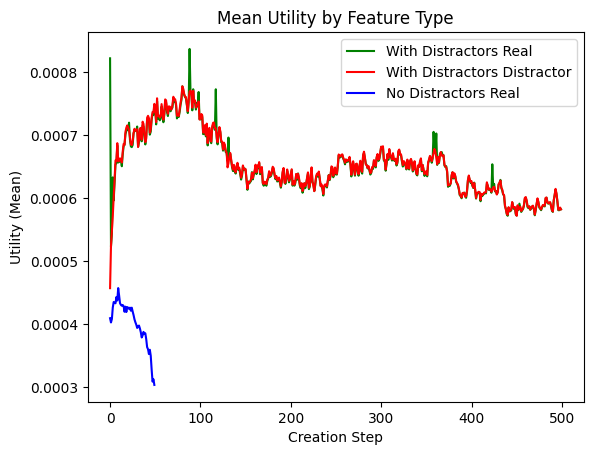

/tmp/ipykernel_71151/147170996.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])
/tmp/ipykernel_71151/147170996.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])


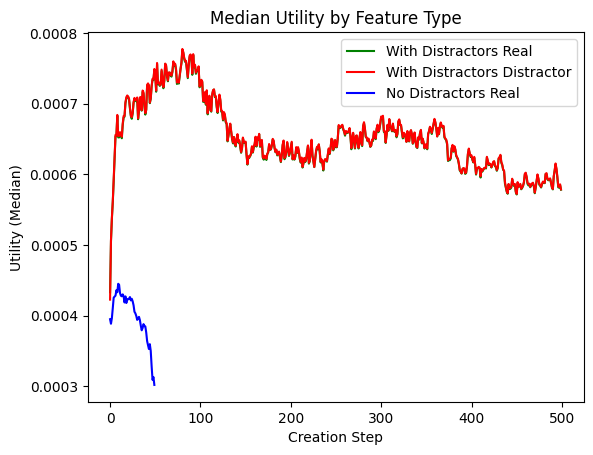

In [28]:
nd_real_means, _ = get_feature_type_means(nd_df)
wd_real_means, wd_distractor_means = get_feature_type_means(wd_df)

plt.plot(wd_real_means, label='With Distractors Real', color='green')
plt.plot(wd_distractor_means, label='With Distractors Distractor', color='red')
plt.plot(nd_real_means, label='No Distractors Real', color='blue')

plt.title('Mean Utility by Feature Type')
plt.xlabel('Creation Step')
plt.ylabel('Utility (Mean)')

plt.legend()
plt.show()


nd_real_means, _ = get_feature_type_means(nd_df, metric='median')
wd_real_means, wd_distractor_means = get_feature_type_means(wd_df, metric='median')

plt.plot(wd_real_means, label='With Distractors Real', color='green')
plt.plot(wd_distractor_means, label='With Distractors Distractor', color='red')
plt.plot(nd_real_means, label='No Distractors Real', color='blue')

plt.xlabel('Creation Step')
plt.ylabel('Utility (Median)')
plt.title('Median Utility by Feature Type')

plt.legend()
plt.show()

/tmp/ipykernel_71151/147170996.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])
/tmp/ipykernel_71151/147170996.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])


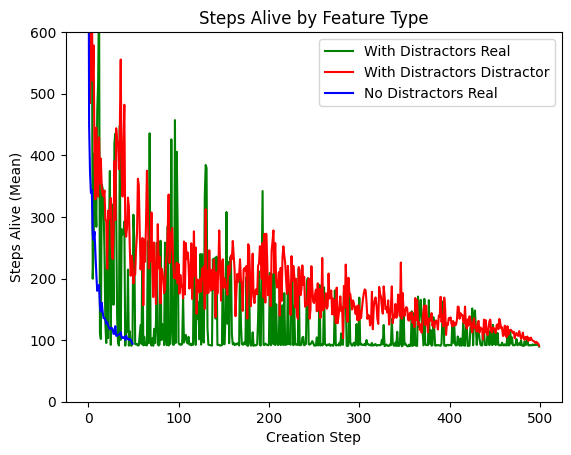

/tmp/ipykernel_71151/147170996.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])
/tmp/ipykernel_71151/147170996.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])


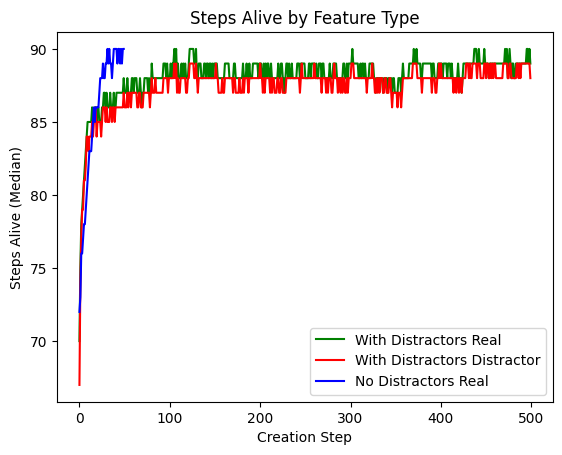

In [30]:
nd_real_means, _ = get_feature_type_steps_alive(nd_df)
wd_real_means, wd_distractor_means = get_feature_type_steps_alive(wd_df)

plt.plot(wd_real_means, label='With Distractors Real', color='green')
plt.plot(wd_distractor_means, label='With Distractors Distractor', color='red')
plt.plot(nd_real_means, label='No Distractors Real', color='blue')
plt.legend()

plt.xlabel('Creation Step')
plt.ylabel('Steps Alive (Mean)')

plt.ylim(0, 600)
plt.title('Steps Alive by Feature Type')

plt.show()


nd_real_means, _ = get_feature_type_steps_alive(nd_df, metric='median')
wd_real_means, wd_distractor_means = get_feature_type_steps_alive(wd_df, metric='median')

plt.plot(wd_real_means, label='With Distractors Real', color='green')
plt.plot(wd_distractor_means, label='With Distractors Distractor', color='red')
plt.plot(nd_real_means, label='No Distractors Real', color='blue')


plt.xlabel('Creation Step')
plt.ylabel('Steps Alive (Median)')
plt.title('Steps Alive by Feature Type')

plt.legend()
plt.show()

/tmp/ipykernel_71151/4224533958.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])
/tmp/ipykernel_71151/4224533958.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([pd.cut(df['creation_step'], bins), 'feature_type'])


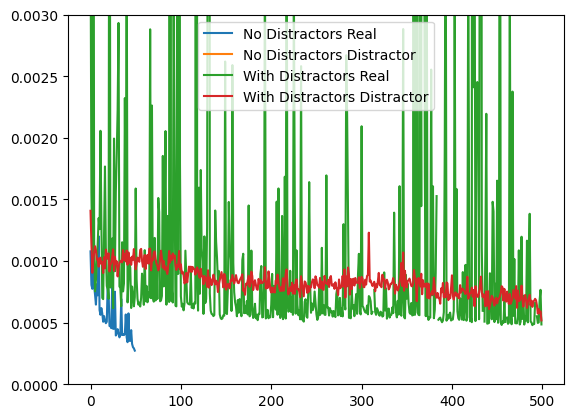

In [17]:
nd_real_means, nd_distractor_means = get_feature_type_means(nd_df[nd_df['steps_alive'] >= 200])
wd_real_means, wd_distractor_means = get_feature_type_means(wd_df[wd_df['steps_alive'] >= 200])

plt.plot(nd_real_means, label='No Distractors Real')
plt.plot(nd_distractor_means, label='No Distractors Distractor')
plt.plot(wd_real_means, label='With Distractors Real')
plt.plot(wd_distractor_means, label='With Distractors Distractor')

plt.ylim(0.0, 0.003)

plt.legend()
plt.show()

# Old DB code for when cannot fit all data into memory

In [2]:
# Connect to the no distractors database
nd_conn = sqlite3.connect('./data/no_distractors_utility_stats.db')
nd_cursor = nd_conn.cursor()

# Connect to the with distractors database
wd_conn = sqlite3.connect('./data/distractors_utility_stats.db')
wd_cursor = wd_conn.cursor()

In [33]:
# Get schema of the main table by querying the first row
nd_cursor.execute("SELECT * FROM feature_stats LIMIT 1")
print("Table schema:")
print("\n".join(f"{description[0]} ({description[1]})" for description in nd_cursor.description))

Table schema:
id (None)
creation_step (None)
pruned_step (None)
feature_type (None)
utilities (None)


In [5]:
nd_cursor.execute("SELECT COUNT(id) FROM feature_stats")
count = nd_cursor.fetchone()[0]
print(f"Total records: {count}")

Total records: 2565094


In [6]:
def get_feature_stats(
    conn: sqlite3.Connection,
    start_step: int,
    end_step: int,
    max_features: Optional[int] = None,
) -> List[FeatureUtilityStats]:
    """Gets feature statistics from the database for features active during the specified time period.

    Args:
        conn: SQLite database connection
        start_step: Starting step to get features from
        end_step: Ending step to get features from 
        max_features: Optional maximum number of features to return. If specified, features
            are randomly sampled.

    Returns:
        List of FeatureUtilityStats objects sorted by creation step, containing feature
        statistics for features that were active during the specified time period.
    """
    cursor = conn.cursor()
    
    if max_features is not None:
        query = """
            SELECT id, creation_step, pruned_step, feature_type, utilities 
            FROM feature_stats 
            WHERE creation_step <= ? AND pruned_step >= ?
            ORDER BY RANDOM()
            LIMIT ?
        """
        cursor.execute(query, (end_step, start_step, max_features))
    else:
        query = """
            SELECT id, creation_step, pruned_step, feature_type, utilities 
            FROM feature_stats 
            WHERE creation_step <= ? AND pruned_step >= ?
        """
        cursor.execute(query, (end_step, start_step))

    # Convert rows to list of dicts with utilities as float arrays
    feature_stats = []
    for row in cursor.fetchall():
        feature_dict = {
            'id': row[0],
            'creation_step': row[1], 
            'pruned_step': row[2],
            'feature_type': row[3],
            'utilities': array.array('f', row[4]).tolist() # Convert bytes to float array
        }
        feature_stats.append(FeatureUtilityStats(**feature_dict))

    # Sort by creation step to maintain deterministic ordering
    feature_stats.sort(key=lambda x: x.id)

    print(f"Querried {len(feature_stats)} features active between steps {start_step} and {end_step}")
    return feature_stats


In [7]:
nd_start_features_sample = get_feature_stats(nd_conn, 0, 2000, 1000)
nd_mid_features_sample = get_feature_stats(nd_conn, 50_000, 52_000, 1000)
nd_end_features_sample = get_feature_stats(nd_conn, 98_000, 100_000, 1000)

Querried 1000 features active between steps 0 and 2000
Querried 1000 features active between steps 50000 and 52000
Querried 1000 features active between steps 98000 and 100000


In [80]:
wd_start_features_sample = get_feature_stats(wd_conn, 0, 2000, 1000)
wd_mid_features_sample = get_feature_stats(wd_conn, 500_000, 502_000, 1000)
wd_end_features_sample = get_feature_stats(wd_conn, 998_000, 1_000_000, 1000)

Querried 1000 features active between steps 0 and 2000
Querried 1000 features active between steps 500000 and 502000
Querried 1000 features active between steps 998000 and 1000000


In [71]:
DEFAULT_COLOR_MAP = {
    'real': 'blue',
    'distractor': 'red',
}

LOG_FREQ = 10

def plot_feature_stats(
    feature_stats: List[FeatureUtilityStats],
    start_step: int,
    end_step: int,
    color_map: Optional[Dict[str, str]] = None,
):
    if color_map is None:
        color_map = DEFAULT_COLOR_MAP
        
    start_step = (start_step + LOG_FREQ - 1) // LOG_FREQ * LOG_FREQ # Round up to nearest LOG_FREQ
    end_step = (end_step + LOG_FREQ - 1) // LOG_FREQ * LOG_FREQ # Round up to nearest LOG_FREQ
    
    plt.figure(figsize=(14, 6))
    plot_range = end_step - start_step
    # Collect all line data
    line_data = {'real': [], 'distractor': []}
    start_points = {'real': [], 'distractor': []}
    end_points = []
    
    for feature in feature_stats:
        feature_start = (feature.creation_step + LOG_FREQ - 1) // LOG_FREQ * LOG_FREQ # Round up to nearest LOG_FREQ
        feature_end = (feature.pruned_step + LOG_FREQ - 1) // LOG_FREQ * LOG_FREQ # Round down to nearest LOG_FREQ
        
        x_start = max(0, feature_start - start_step)
        x_end = min(plot_range, min(end_step, feature_end) - max(start_step, feature_start))
        
        util_start_idx = max(0, start_step - feature_start) // LOG_FREQ
        
        n_available_steps = min(plot_range, min(end_step, feature_end) - max(start_step, feature_start))
        
        x_end = x_start + n_available_steps
        util_end_idx = util_start_idx + n_available_steps // LOG_FREQ
        
        plot_xs = np.arange(x_start, x_end, LOG_FREQ)
        plot_ys = np.array(feature.utilities[util_start_idx:util_end_idx])
        
        if len(plot_xs) == 0:
            continue
            
        # print(
        #     'X start/end:', (x_start, x_end),
        #     'Feature start/end:', (feature_start, feature_end),
        #     'Util start/end:', (util_start_idx, util_end_idx),
        #     '# points:', len(plot_xs) , '/', len(feature.utilities),
        #     'Plots end:', util_end_idx == len(feature.utilities),
        # )
            
        # Store line data
        line_data[feature.feature_type].append((plot_xs + start_step, plot_ys))
        
        # Store start point if it's the first utility
        if util_start_idx == 0:
            start_points[feature.feature_type].append((plot_xs[0] + start_step, plot_ys[0]))
            
        # Store end point if it's the last utility
        if util_end_idx == len(feature.utilities):
            end_points.append((plot_xs[-1] + start_step, plot_ys[-1]))
    
    # Plot all lines
    for feature_type, lines in line_data.items():
        for x, y in lines:
            plt.plot(x, y, color=color_map[feature_type], label=feature_type, alpha=0.3)
            
    # Plot all start points
    for feature_type, points in start_points.items():
        if not points:
            continue
        x, y = zip(*points)
        color = 'navy' if feature_type == 'real' else 'firebrick'
        plt.scatter(x, y, color=color, alpha=0.5, s=13, zorder=2)
        
    # Plot all end points
    if end_points:
        x, y = zip(*end_points)
        plt.scatter(x, y, color='black', alpha=0.3, s=13, zorder=2)
    
    plt.xlim(start_step, end_step)
    plt.xlabel('step')
    plt.ylabel('utility')
    plt.ylim(0)
    plt.title(f'Feature utilities between steps {start_step} and {end_step}')
    # plt.legend(color_map.keys())


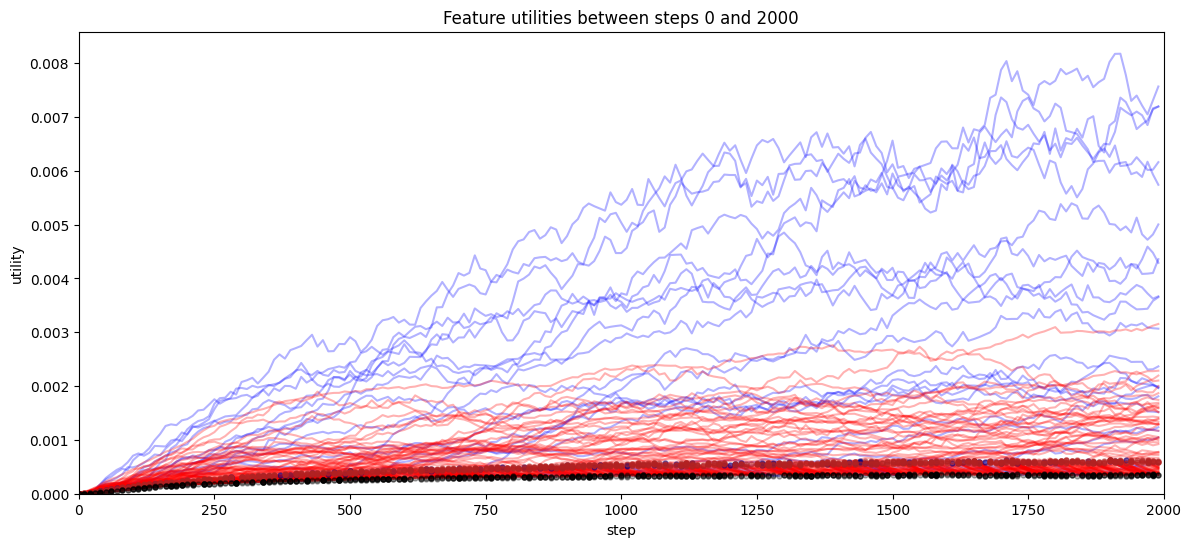

In [72]:
plot_feature_stats(wd_start_features_sample, 0, 2000)
plt.show()

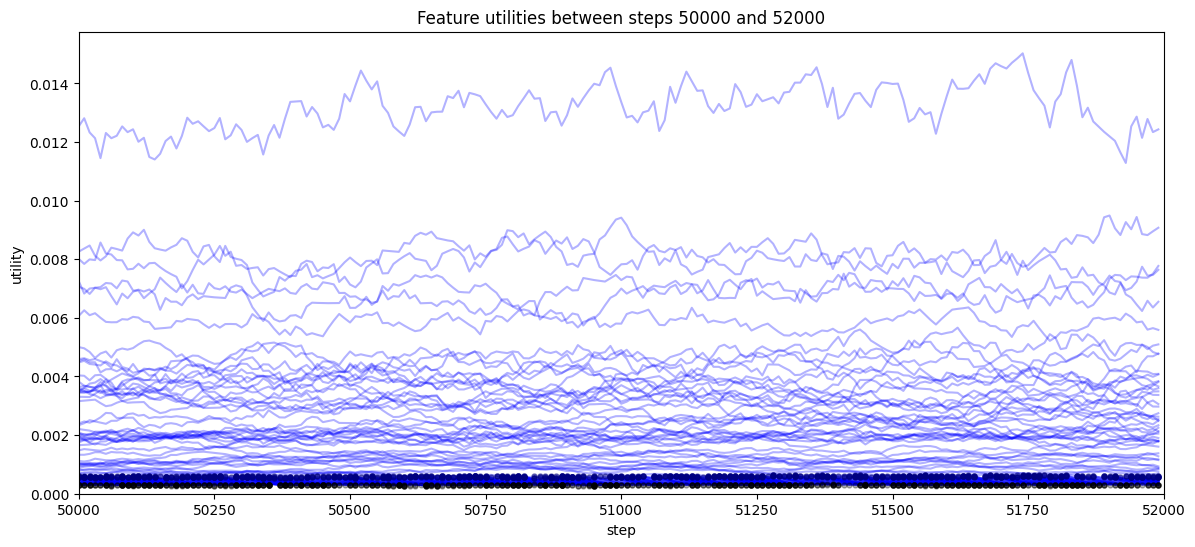

In [73]:
plot_feature_stats(nd_mid_features_sample, 50_000, 52_000)
plt.show()

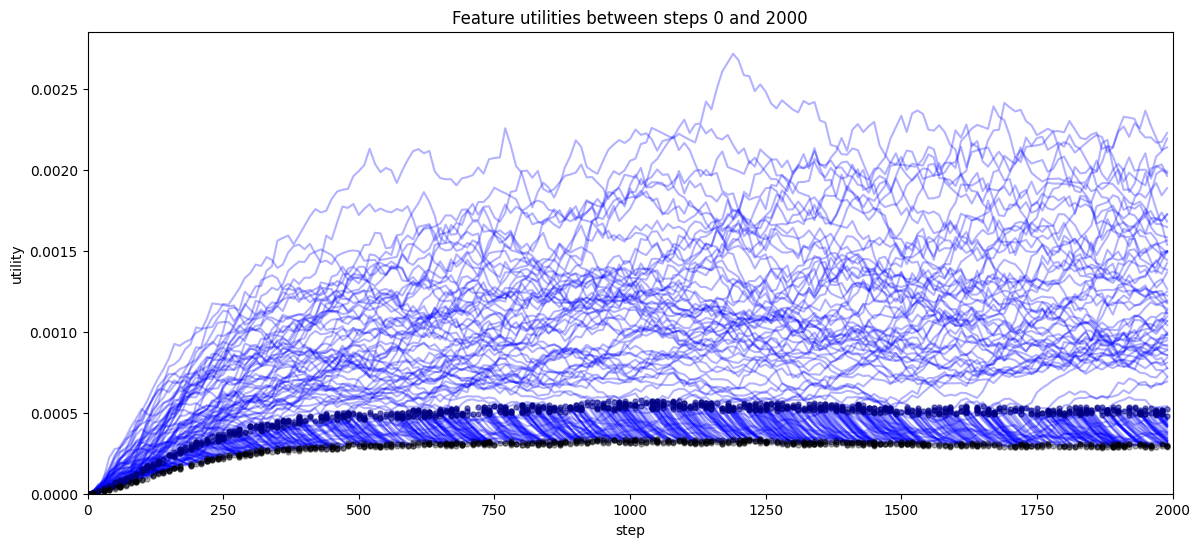

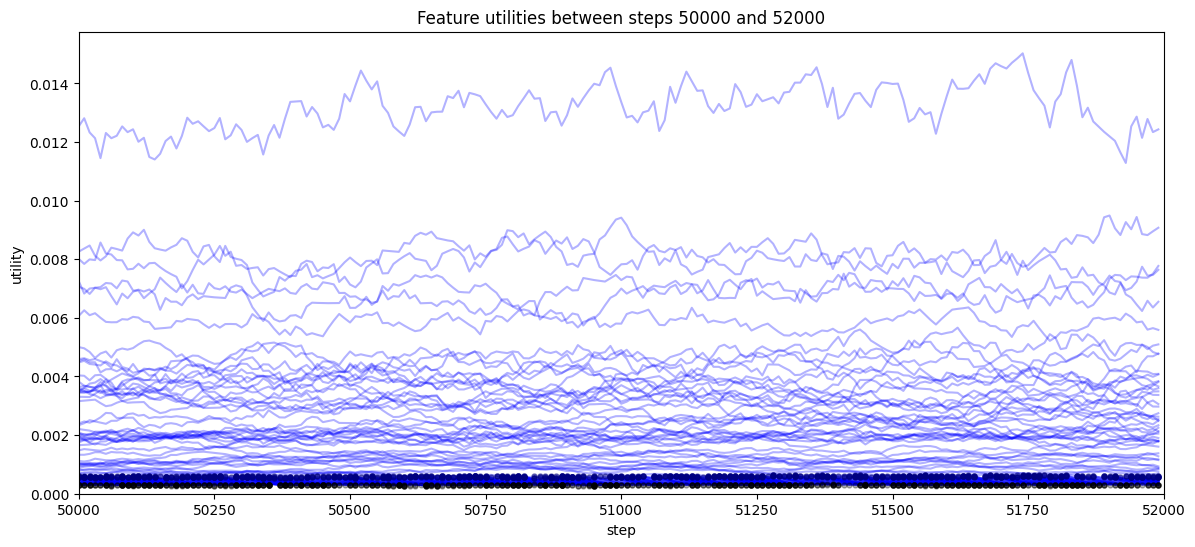

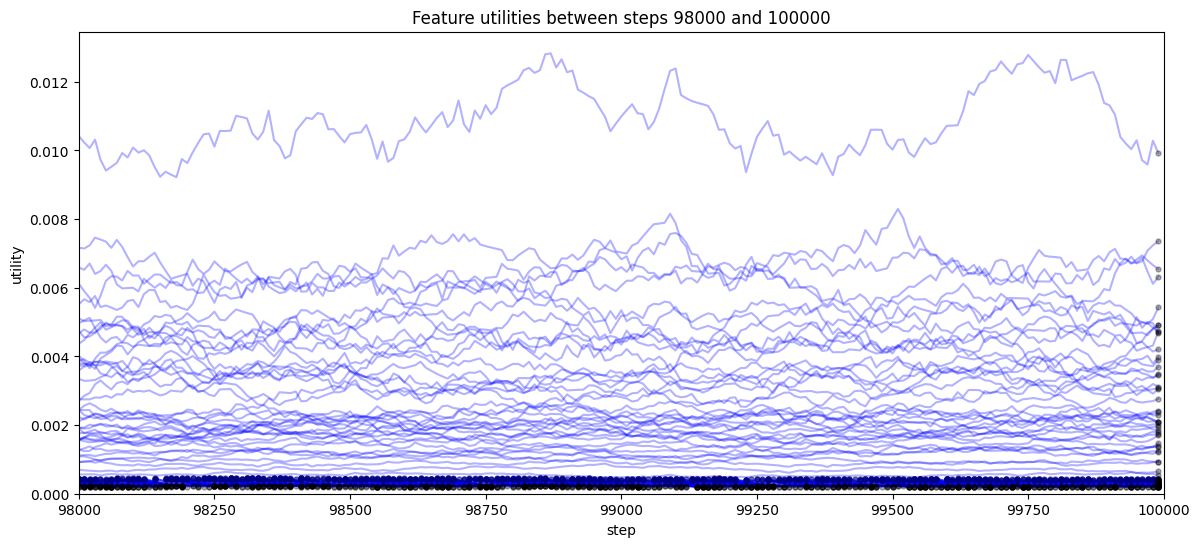

In [74]:
plot_feature_stats(nd_start_features_sample, 0, 2000)
plt.show()

plot_feature_stats(nd_mid_features_sample, 50_000, 52_000)
plt.show()

plot_feature_stats(nd_end_features_sample, 98_000, 100_000)
plt.show()

In [78]:
len(wd_start_features_sample)

1000

In [81]:
# for x in wd_mid_features_sample:
#     print(x.creation_step, x.pruned_step)

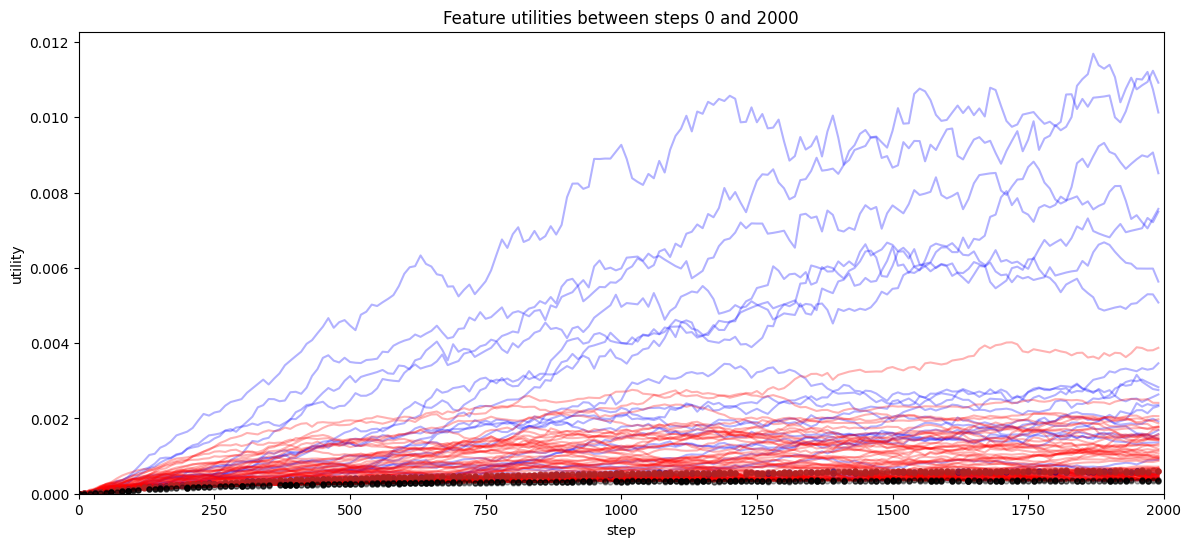

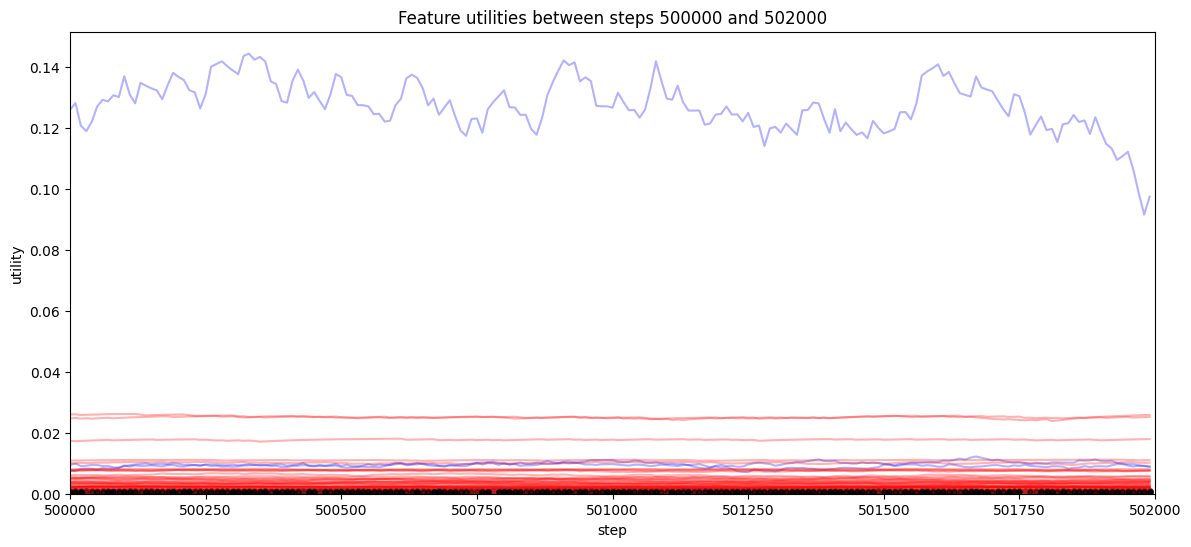

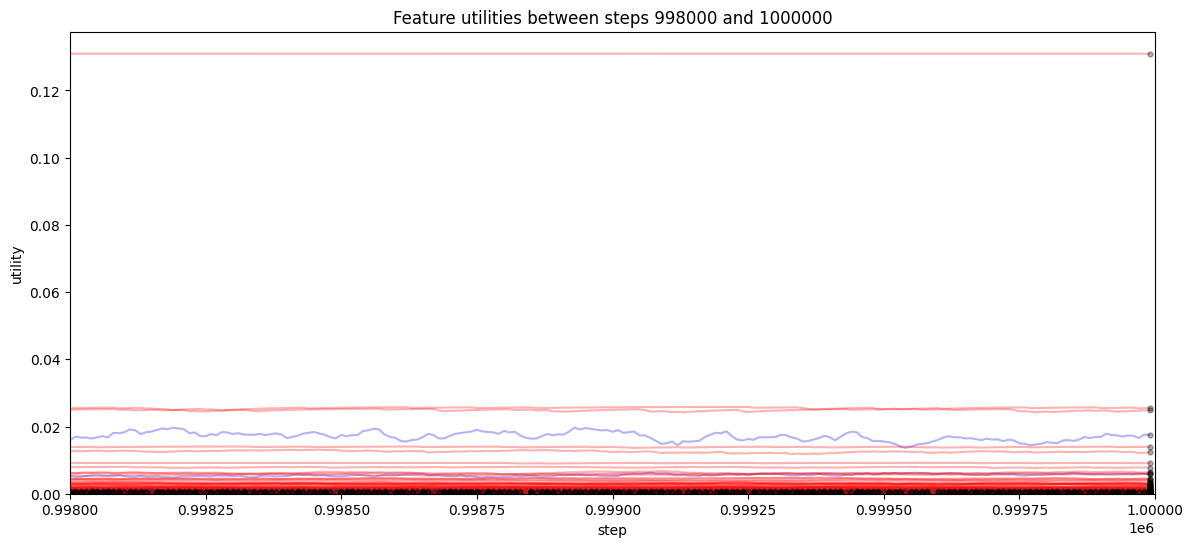

In [82]:
plot_feature_stats(wd_start_features_sample, 0, 2000)
plt.show()

plot_feature_stats(wd_mid_features_sample, 500_000, 502_000)
plt.show()

plot_feature_stats(wd_end_features_sample, 998_000, 1_000_000)
plt.show()

In [83]:
samples = get_feature_stats(wd_conn, 500_000, 502_000, 10_000)

Querried 10000 features active between steps 500000 and 502000


In [85]:
real_samples = [s for s in samples if s.feature_type == 'real']

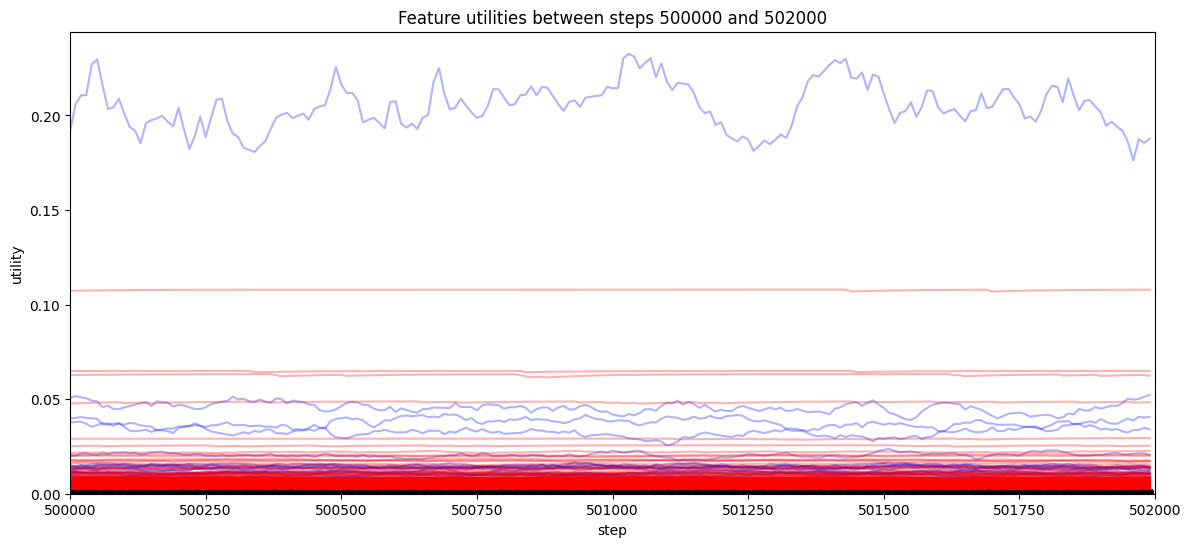

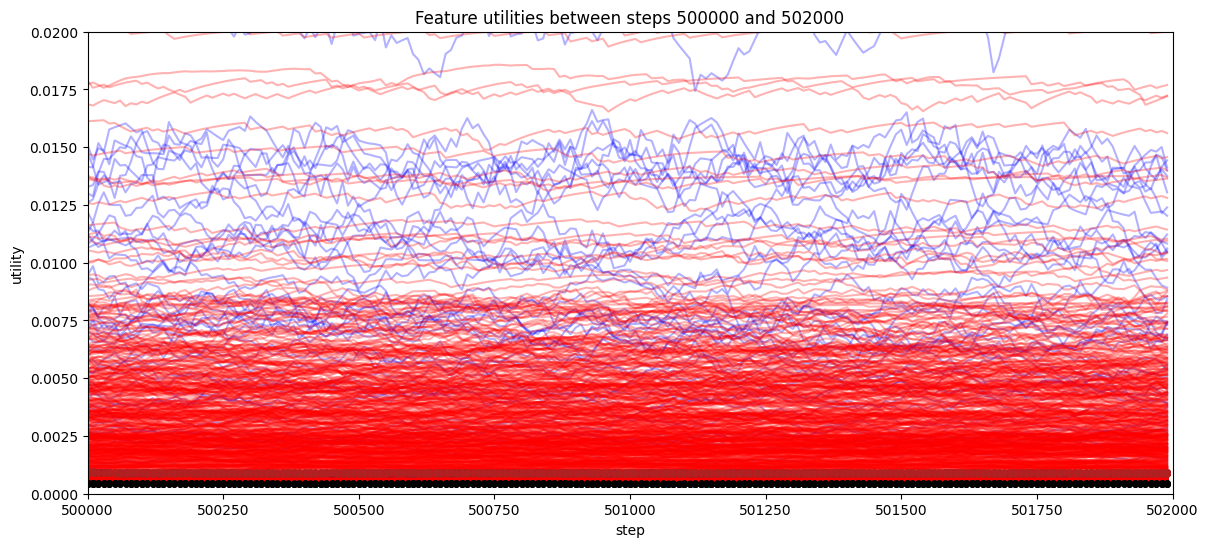

In [89]:
plot_feature_stats(samples, 500_000, 502_000)
plt.show()

plot_feature_stats(samples, 500_000, 502_000)
plt.ylim(0.0, 0.02)
plt.show()

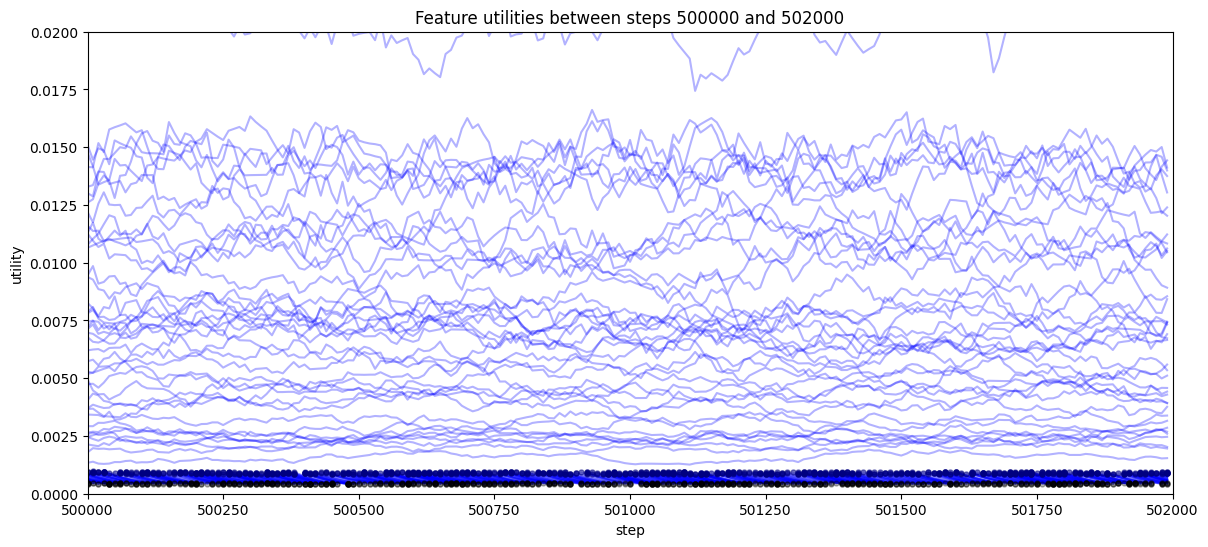

In [88]:
plot_feature_stats(real_samples, 500_000, 502_000)
plt.ylim(0.0, 0.02)
plt.show()